# Бутстрап

<img src="https://github.com/Yorko/mlcourse_open/blob/master/img/bootstrap.jpg?raw=true" width="70%">

Позволяет просто и быстро оценивать самые разные статистики (доверительные интервалы, дисперсию, корреляцию и так далее) для сложных моделей.

C помощью датчика псевдослучайных чисел сгенерировать практически неограниченное количество псевдовыборок произвольного размера, например, того же как у исходной. На множестве псевдовыборок можно оценить не только анализируемые статистические характеристики, но и изучить их вероятностные распределения. Таким образом, например, оказывается возможным оценить дисперсию или квантили любой статистики независимо от её сложности. Данный метод является методом непараметрической статистики.

Бутстрап-выборки оказываются очень эффективны в оценке распределений на маленьких датасетах.

# Бэггинг

__Бэггинг__ (от англ. "bagging") не имеет ничего общего с мешками - "bags". Слово является сокращением от _bootstrap aggregation_.

<img src="https://github.com/Yorko/mlcourse_open/blob/master/img/bagging.png?raw=true" width="70%">

Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

In [4]:
# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

In [5]:
# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

In [6]:
def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

In [7]:
X_train = []
y_train = []

In [8]:
for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0198 (error) = 0.0004 (bias^2)  + 0.0094 (var) + 0.0098 (noise)


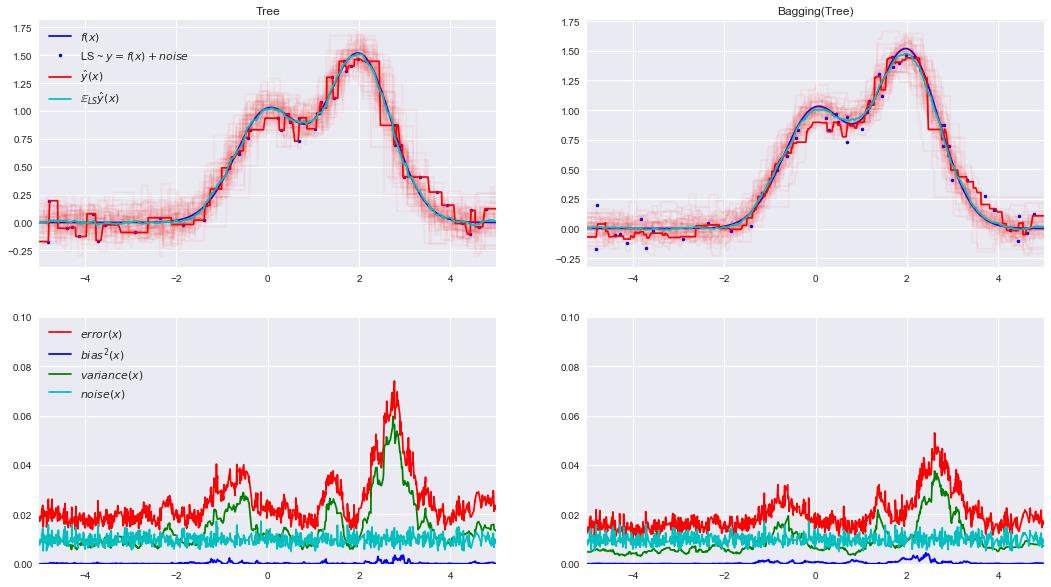

In [10]:
plt.figure(figsize=(18, 10))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

plt.show()

# Что еще?

Формирование случайных подвыборок из данных изначально называется __Pasting__.

Если объекты вытягиваются из датасета с повторениями, это тот самый __Bagging__.

Если, наоборот, выделяются различные _признаковые_ подпространства, то этот метод и называется _методом случайных подпространств_ (__Random Subspaces__).

Наконец, если классификаторы строятся на подвыборках как объектов, так и их признаков, это будет называться __Random Patches__.

# Случайный лес

Лео Брейман нашел применение бутстрэпу не только в статистике, но и в машинном обучении. Он вместе с Адель Катлер усовершенстовал алгоритм случайного леса, предложенный Хо, добавив к первоначальному варианту построение некоррелируемых деревьев на основе CART (то есть использует индекс Джини и [Cost-Complexity Pruning](http://0agr.ru/wiki/index.php/Cost-Complexity_Pruning) как метод стрижки), в сочетании с методом случайных подпространств и бэггинга.

Метод случайных подпространств позволяет снизить коррелированность между деревьями и избежать переобучения. Базовые алгоритмы обучаются на различных подмножествах признакового описания, которые также выделяются случайным образом.

Таким образом, случайный лес — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

# Сверхслучайный лес

Как и в случайных лесах, используется случайное подмножество возможных признаков, но вместо поиска наиболее оптимальных порогов, пороговые значения произвольно выбираются для каждого возможного признака, и наилучший из этих случайно генерируемых порогов выбирается как лучшее правило для разделения узла. Это обычно позволяет немного уменьшить дисперсию модели за счет несколько большего увеличения смещения.

В библиотеке scikit-learn есть реализация ExtraTreesClassifier и ExtraTreesRegressor. Данный метод стоит использовать, когда вы сильно переобучаетесь на случайном лесе или градиентном бустинге.